Pas de dataaugmentation
Pas de changement de lr
Dataset : Fingers

In [1]:
import random

import keras
import re
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D,Dense, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dropout, Lambda
from keras.layers import concatenate
import glob
from keras.applications import ResNet50

## Load model

In [2]:
model = Sequential()
model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=(224, 224, 3)))


In [3]:
model.add(ResNet50(weights='imagenet',
				   include_top=False,
				   classes=3, input_shape=(224,224,3)))

# model.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [4]:
x = model.layers[-2].output
x = Flatten()(x)

In [5]:
x

<KerasTensor: shape=(None, 150528) dtype=float32 (created by layer 'flatten')>

In [6]:
x = Dense(units=128, activation='relu')(x)
output = Dense(units=3, activation='softmax')(x)

In [7]:
model = Model(inputs=model.input, outputs=output)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_input (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 19,268,099
Trainable params: 19,268,099
Non-trainable params: 0
_________________________________________________________________


## Load their data

In [9]:
from PIL import Image
import numpy as np

def load_their(set):

    xdata = []
    ydata = []

    file_list = glob.glob(
        r"A:/F/%(set)s/*.png" % {"set": set})
    for file in file_list:
        classe = file[-6]
        if classe not in ["0", "2", "5"]:
            continue
        classe = {"2": 1, "0": 0, "5": 2}[classe]
        ydata.append(classe)
        # im = imread(file)

        image = Image.open(file)

        im = image.resize((224, 224))
        im = im.rotate(90, Image.NEAREST, expand = 1)

        # Transformer l'image redimensionnée en un tableau NumPy
        im = np.array(im)
        im = im.reshape((224,224,1))
        im = np.concatenate([im, im, im], axis=2)
        xdata.append(im[:, :, :3])

    return xdata, ydata

from sklearn.model_selection import train_test_split
xtrain, ytrain = load_their("train")
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1, random_state=42, shuffle=True)
xtest, ytest = load_their("test")

C:\Users\iArno-Computer3\AppData\Local\Temp\ipykernel_6204\1976738579.py:22: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  im = im.rotate(90, Image.NEAREST, expand = 1)


## Load Data

In [10]:
# from tqdm import tqdm
# import random
# def load(set: str):
#     xtrain = []
#     ytrain = []
#     print(set)
#     train_num_files = 0
#     for source in ["Temps1", "Temps2", "Temps3", "Temps0"]:
#         print(source)
#         file_list = glob.glob(
#             r"A:/%(s)s/images/%(set)s/*.png" % {"s": source, "set": set})
#         if source == "Temps0":
#             file_list = random.choices(file_list, k=200)
#         # print(len(file_list))
#         for file in tqdm(file_list, desc="Loading..."):
#             p = 'A:/%(s)s/labels/%(set)s/' % {"s": source, "set": set}
#             file_label = p + file[len(p):]
#             file_label = file_label[:-4]
#             file_label = file_label+'.txt'
#             if os.path.isfile(file_label):
#                 f = open(file_label,"r+")
#                 a = f.read()
#                 if len(a)>=1:
#                     im = imread(file)[:, :, :3]
#                     train_num_files += 1
#                     xtrain.append(im)
#                     ytrain.append([int(a[0])])
#                 f.close()
#     return xtrain, ytrain
#
# xtrain, ytrain = load("train")
# xval, yval = load("val")
# xtest, ytest = load("test")
# # xtest2, ytest2 = load("train", mode="choices", k=200, sources=("Temps0",))

In [11]:
filepath = 'shifumi_from_mobil.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [12]:
import tensorflow_addons as tfa
f1_score = tfa.metrics.F1Score(num_classes = 3, average = None, name = "f1_score")

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score])

In [14]:
from keras.utils import to_categorical

In [15]:
xtrain = np.asarray(xtrain)
xval = np.asarray(xval)
xtest = np.asarray(xtest)

In [16]:
ytrain = to_categorical(ytrain)
yval = to_categorical(yval)
ytest = to_categorical(ytest)

## Data augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = []
factor = 0
datagen.append(ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    # rotation_range=60*factor,
    # width_shift_range=0.2*factor,
    # height_shift_range=0.2*factor,
    # # brightness_range=(-1, 1),
    # zoom_range=(0.33*factor + (1-factor),1.3*factor + (1-factor)),
    horizontal_flip=True,
    # validation_split=0.1
))
random.seed(42)
datagen[0].fit(xtrain)

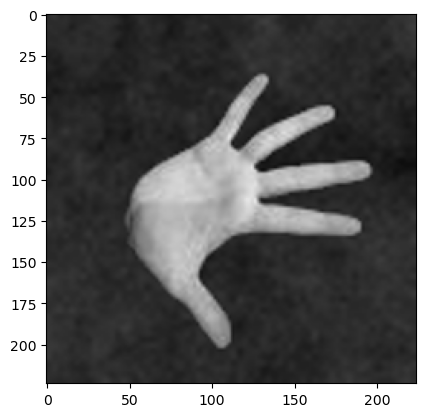

In [18]:
plt.imshow(datagen[-1].random_transform(xtrain[350], seed=42))

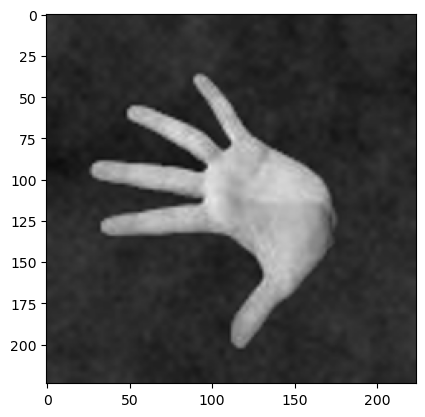

In [19]:
plt.imshow(xtrain[350])

In [20]:
import sys
sys.getsizeof(xtrain)

1219276952

## Train

In [22]:
metrics={"f1_score": [], "val_f1_score": []}

for i in range(10):
    # print("Introduction de variations : %(ii)d/10" % {"ii": i})
    factor = 0

    # K.set_value(model.optimizer.learning_rate, 0.0001*factor + 0.01*(1-factor))
    for epochs in range(1):
        history = model.fit(datagen[0].flow(xtrain, ytrain, batch_size=10),
              validation_data=datagen[0].flow(xval, yval, batch_size=10),
              batch_size=10,
              # steps_per_epoch=len(xtrain) // 10,
              epochs=1, verbose=1, callbacks=callbacks)

        for k in metrics.keys():
            metrics[k].extend(history.history[k])
        # if history[-1].history["val_accuracy"][0] == 1:
        #     break

806/810 [============================>.] - ETA: 0s - loss: 193.6618 - accuracy: 0.9754 - f1_score: 0.9754
Epoch 1: val_loss improved from inf to 0.00000, saving model to shifumi_from_mobil.hdf5
808/810 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 1: val_loss did not improve from 0.00000
810/810 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 1: val_loss did not improve from 0.00000
807/810 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 1: val_loss did not improve from 0.00000
805/810 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 1: val_loss did not improve from 0.00000
809/810 [============================>.] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000
Epoch 1: val_loss did not improve from 0.00000
808/810 [======================

On observe que le resnet n'arrive pas à comprendre les données dès lors qu'on introduit un peu de data augmentation, et ce même si on l'introduit progressivement.

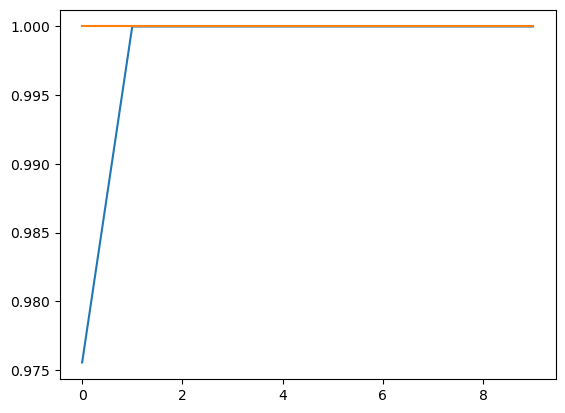

In [23]:
import matplotlib.pyplot as plt
#
# metrics={"f1_score": [], "val_f1_score": []}
# for h in history:
# 	for k in metrics.keys():
# 		metrics[k].extend(h.history[k])

plt.plot(metrics["f1_score"])
plt.plot(metrics["val_f1_score"])
plt.show()

In [24]:
callbacks[0].model.evaluate(xtest, ytest)

57/57 [==============================] - 9s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000


[0.0, 1.0, 1.0]